# Contenido

- [Descripción del proyecto](#descripción-del-proyecto)
- [Importación de datos](#importación-de-datos)
- [Preprocesamiento de los datos](#preprocesamiento-de-los-datos)
    - [Contract](#contract)
    - [Personal](#personal)
    - [Internet](#internet)
    - [Phone](#phone)
- [EDA](#eda)
    - [¿Cuánto duró el contrato con la empresa?](#cuánto-duró-el-contrato-con-la-empresa)
    - [Cargos mensuales de los clientes](#cargos-mensuales-de-los-clientes)
    - [Los clientes que terminaron su contrato ¿tenían pareja e hijos?](#los-clientes-que-terminaron-su-contrato-tenían-pareja-e-hijos)
    - [¿El tipo de contrato es igual entre los clientes que terminaron su contrato y ls clientes que siguen con su contrato?](#el-tipo-de-contrato-es-igual-entre-los-clientes-que-terminaron-su-contrato-y-ls-clientes-que-siguen-con-su-contrato)
- [Modelos](#modelos)
    - [Juntando los datasets](#juntando-los-datasets)
    - [Convertir valores Yes y No](#convertir-valores-yes-y-no)
    - [Codificación OHE](#codificación-ohe)
    - [Divisón del dataset](#divisón-del-dataset)
    - [Escalado de características](#escalado-de-características)
    - [Balanceo de clases](#balanceo-de-clases)
    - [Función para modelos](#función-para-modelos)
    - [Árbol de decisión](#árbol-de-decisión)
    - [Bosque Aleatorio de Decisión](#bosque-aleatorio-de-decisión)
    - [Regresión Logística](#regresión-logística)
    - [LightGBM](#lightgbm)
    - [XGBoost](#xgboost)
- [Conclusión](#conclusión)
- [Informe de solución](#informe-de-solución)
    - [Pasos realizados en el plan](#pasos-realizados-en-el-plan)
    - [Dificultades Encontradas](#dificultades-encontradas)
    - [Pasos Clave](#pasos-clave)
    - [Modelo final](#modelo-final)

# Proyecto Final

## Descripción del proyecto <a name="descripcion-del-proyecto">

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Importación de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import numpy as np
import re

Contamos con 4 datasets, los cuales han sido obtenidos de diferentes fuentes
* `contract.csv`: tiene informacaión del contrato
* `personal.csv`: tiene datos personales del cliente
* `internet.csv`: tiene información sobre los servicios de internet
* `phone.csv`: tiene información sobre los servicios telefónicos

In [2]:
# Importación de los datasets
contract_df = pd.read_csv('datasets/contract.csv')
personal_df = pd.read_csv('datasets/personal.csv')
internet_df = pd.read_csv('datasets/internet.csv')
phone_df = pd.read_csv('datasets/phone.csv')

## Preprocesamiento de los datos

Se van a revisar los 4 DataFrames creados y se buscarán datos ausentes, valores duplicados, etc.

### Contract

In [3]:
contract_df.info()
print()
print(contract_df.describe())
print()
display(contract_df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000



customerID   BeginDate              EndDate            Type  \
551   1352-HNSAW  2014-02-01                   No        Two year   
4441  4825-FUREZ  2016-08-01                   No        Two year   
5380  9689-PTNPG  2019-08-01  2019-10-01 00:00:00  Month-to-month   
5970  4853-OITSN  2019-09-01                   No  Month-to-month   
5604  9432-VOFYX  2018-09-01                   No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
551               Yes  Bank transfer (automatic)          115.60       8220.4  
4441               No           Electronic check           20.25        835.5  
5380              Yes           Electronic check           80.25       144.55  
5970              Yes           Electronic check           89.15       413.25  
5604              Yes           Electronic check           70.80         1207

***Conclusión***

* No hay datos ausentes, pero se observa que el tipo de datos en la columna `'TotalCharges'` es `object`, vamos a cambiarlo a u tipo `float`. Pero antes se va a revisar si hay datos que no sean números, como por ejemplo buscar si hay filas que tienen solamente un espacio en blanco
* También se van a buscar si hay filas repetidas.

In [4]:
# Buscamos si hay strings en nuestra columna de 'TotalCharges'
print(contract_df[contract_df['TotalCharges'] == ' ']['TotalCharges'].count())

11


Con esto sabemos que hay 11 valores en la columna `'TotalCharges'` que solo son strngs con un espacio en blanco. Esto representa mucho menos del 1% de nuestro dataset, por lo que se decide cambiar estos valores por el promedio de la columna.

In [5]:
# Primero reemplazamos esos valores a valores NaN
contract_df['TotalCharges'] = contract_df['TotalCharges'].replace(' ', np.nan)

In [6]:
# Ahora cambiamos el tipo de datos por float
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype(float)

In [7]:
# Por último cambiamos los valores ausentes que se crearon por el promedio de la columna
promedio = round(contract_df['TotalCharges'].mean(skipna=True), 2)
contract_df['TotalCharges'].fillna(promedio, inplace=True)

C:\Users\juan_\AppData\Local\Temp\ipykernel_27408\4286767893.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract_df['TotalCharges'].fillna(promedio, inplace=True)


Ahora buscamos datos duplicados

In [8]:
print(contract_df[contract_df.duplicated()].sum())

customerID            0
BeginDate             0
EndDate               0
Type                  0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: object


No hay datos duplicados.

### Personal

In [9]:
personal_df.info()
print()
display(personal_df.sample(5))
print()
print(personal_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



customerID  gender  SeniorCitizen Partner Dependents
214   2504-DSHIH    Male              1     Yes         No
5569  0013-EXCHZ  Female              1     Yes         No
6911  0508-SQWPL  Female              0     Yes        Yes
2973  0596-BQCEQ  Female              0     Yes        Yes
5298  5647-FXOTP  Female              1     Yes         No


       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [10]:
# Se buscan valores duplicados
print(personal_df[personal_df.duplicated].sum())

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: object


***Conclusión***

No hay valores ausentes, las columnas presentan un tipo de datos adecuado y no hay datos duplicados ni valores ausentes

### Internet

In [11]:
internet_df.info()
print()
display(internet_df.sample(5))
print()
print(internet_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
3762  3389-YGYAI     Fiber optic             No          Yes              Yes   
2434  8809-RIHDD     Fiber optic             No          Yes              Yes   
4190  6559-PDZLR     Fiber optic             No           No              Yes   
2942  8885-QSQBX             DSL            Yes           No               No   
4191  8992-OBVDG             DSL             No           No              Yes   

     TechSupport StreamingTV StreamingMovies  
3762          No         Yes             Yes  
2434          No         Yes             Yes  
4190         Yes         Yes             Yes  
2942          No          No              No  
4191          No          No             Yes


        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3186-AJIEK     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785  


In [12]:
# Se buscan valores duplicados
print(internet_df[internet_df.duplicated].sum())

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: object


***Conclusión***

No hay valores ausentes, las columnas presentan un tipo de datos adecuado y no hay datos duplicados ni valores ausentes

### Phone

In [13]:
phone_df.info()
print()
display(phone_df.sample(5))
print()
print(phone_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



customerID MultipleLines
707   5676-CFLYY            No
4797  8058-INTPH            No
2278  2333-KWEWW            No
786   3313-QKNKB           Yes
5747  7718-RXDGG            No


        customerID MultipleLines
count         6361          6361
unique        6361             2
top     3186-AJIEK            No
freq             1          3390


***Conclusión***

No hay valores ausentes, las columnas presentan un tipo de datos adecuado y no hay datos duplicados ni valores ausentes.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

<p><b>Exploración de Datos:</b></p>
<p>Has hecho un gran trabajo con la exploración de datos. El uso de <code>info()</code>, <code>head()</code> y <code>describe()</code> es adecuado y te permite obtener una visión general completa de los datos. La forma en que presentas conclusiones intermedias en cada sección es muy útil para mantener una comprensión clara del progreso del análisis.</p>

<p><b>Sugerencias para Mejorar:</b></p>
<p>En lugar de usar múltiples <code>print()</code> para separar los documentos, considera utilizar los módulos de HTML de IPython. Esto te permitirá organizar mejor los resultados y mejorar la presentación visual del análisis.</p>

<p><b>Desequilibrio de Clases:</b></p>
<p>Has identificado correctamente que hay más clientes que no han terminado su contrato, lo cual nos enfrenta a un problema de desequilibrio de clases. Te recomiendo investigar los efectos de este desequilibrio si decides utilizar clasificadores o modelos de machine learning. Técnicas como el submuestreo, sobremuestreo y el uso de algoritmos específicos para datos desequilibrados pueden ser útiles.</p>

<p><b>Visualización de Datos:</b></p>
<p>Considera incluir librerías como Seaborn o Plotly para mejorar tus visualizaciones. Veo que ya tienes un buen dominio de Matplotlib, y estas herramientas adicionales pueden ofrecerte más opciones y facilidad para crear gráficos más interactivos y estéticamente agradables.</p>

<p><b>Conclusión:</b></p>
<p>Tu proyecto va muy bien y muestra un gran dominio del tema. Continúa con el buen trabajo y considera las sugerencias anteriores para robustecer aún más tu análisis y presentación de datos.</p>

</div>


## EDA

Vamos a revisar cuántas personas han terminado el contrato contra los que siguen vigente con el mismo. Para esto vamos a agregar una nueva columna que al DataFrame `contract_df` que indique con un cero si el cliente sigue teniendo un contrato y con un uno si el cliente ya dió por terminado el contrato.

Para esto se hará uso de una función.

In [14]:
# Función que coloca cero o 1 en la nueva columna si se ha terminado el contrato
def ContractEnding(end_date):
    if end_date == 'No':
        return 0
    else:
        return 1

In [15]:
# Llamada a la función para crear la nueva columna
contract_df['ContractEnd'] = contract_df['EndDate'].apply(ContractEnding)

# Verificación del cambio realizado
display(contract_df.sample(2))

customerID   BeginDate EndDate            Type PaperlessBilling  \
3594  9026-LHEVG  2019-05-01      No  Month-to-month               No   
2816  0536-ACXIP  2014-02-01      No        Two year              Yes   

         PaymentMethod  MonthlyCharges  TotalCharges  ContractEnd  
3594  Electronic check           40.75         359.4            0  
2816  Electronic check          109.55        8165.1            0

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

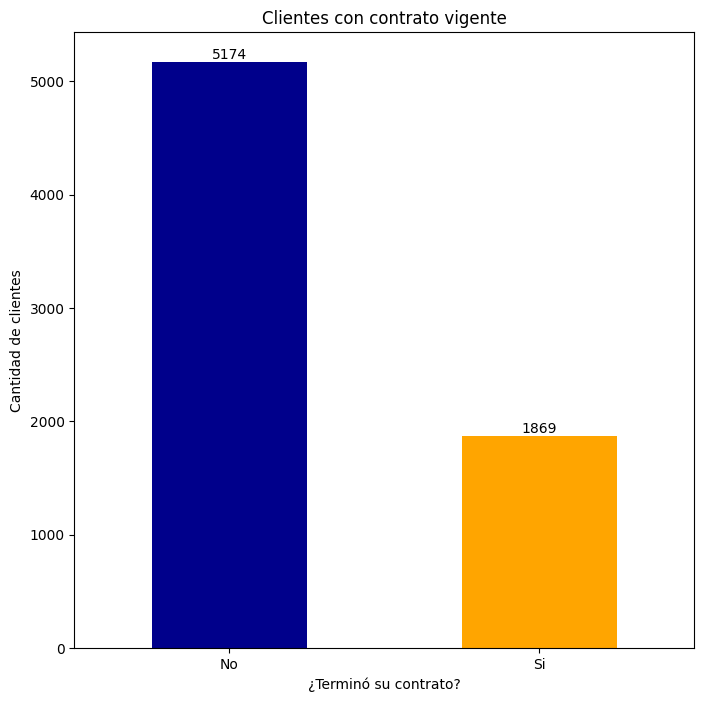

In [17]:
# Graficamos la cantidad de personas con contrato y sin contrato
fig, ax = plt.subplots(figsize=(8,8))

dft = contract_df['ContractEnd'].map({0:'No', 1:'Si'}).value_counts()
dft.plot(kind='bar', ax=ax, color=['darkblue', 'orange'])
ax.set_title('Clientes con contrato vigente')
ax.set_xlabel('¿Terminó su contrato?')
ax.set_ylabel('Cantidad de clientes')

# Coloca las etiquetas a las barras
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), f'{p.get_height():.0f}', ha='center', va='bottom')
    
# Rota las etiquetas del eje x
for tick in ax.get_xticklabels():
    tick.set_rotation(360)

***Conclusión***

Se observa que más de 5000 clientes aún tienen un contrato y poco menos de 2000 clientes terminaron su contrato con la empresa

### ¿Cuánto duró el contrato con la empresa?

Vamos a realizar un análisis para saber la duración de los contratos de los clientes que terminaron su contrato

In [18]:
# Creamos un df que contiene sólo las columnas de 'BeginDate' y 'EndDate' de las personas que ya no tienen contrato
duration_df = contract_df[contract_df['ContractEnd'] == 1][['BeginDate', 'EndDate']]

In [19]:
# Ahora cambiamos el tipo de objeto de las fechas
duration_df['BeginDate'] = pd.to_datetime(duration_df['BeginDate'])
duration_df['EndDate'] = pd.to_datetime(duration_df['EndDate'])

In [20]:
# Calculamos los días meses de duaración de los contratos
duration_df['Duration'] = round((duration_df['EndDate'] - duration_df['BeginDate']).dt.days / 30, 1)

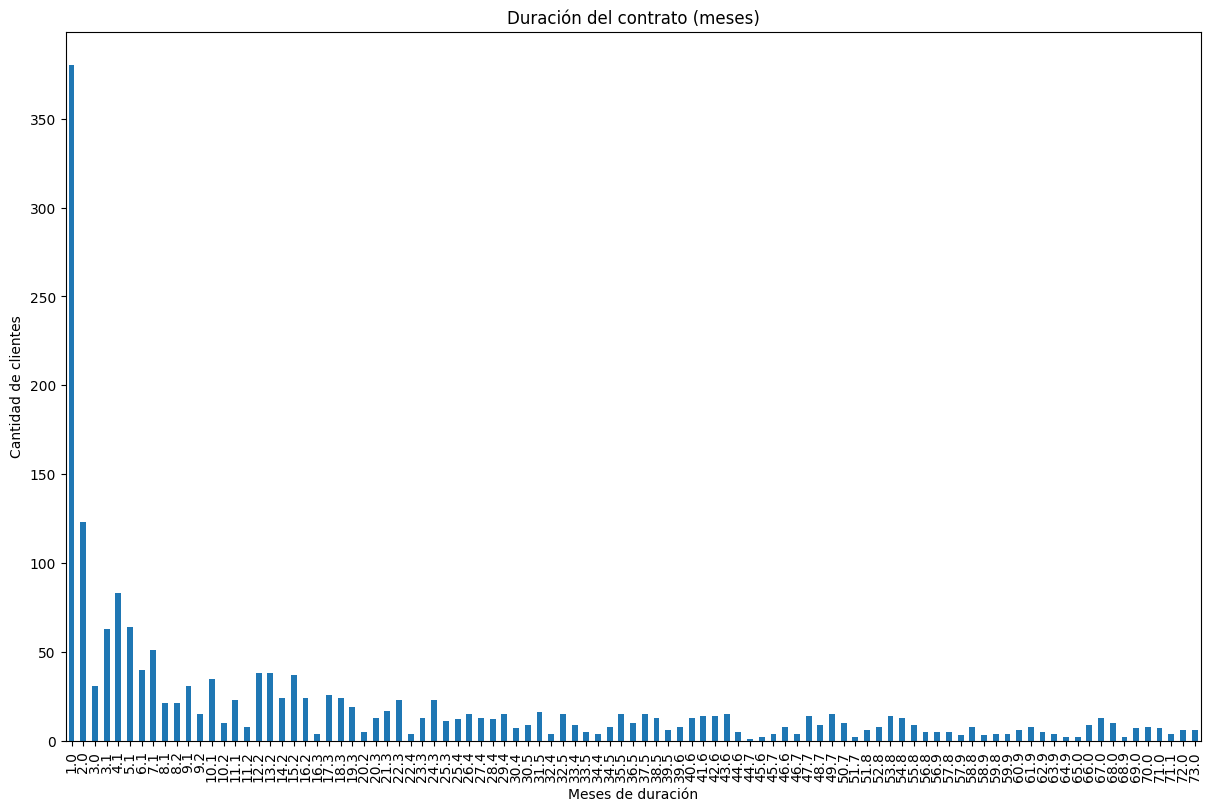

In [21]:
# Grafiquemos los meses que duró el contrato
fig, ax = plt.subplots(figsize=(12,8), layout='constrained')

dft = duration_df.groupby('Duration')['Duration'].value_counts()
dft.plot(kind='bar', ax=ax)
ax.set_title('Duración del contrato (meses)')
ax.set_xlabel('Meses de duración')
ax.set_ylabel('Cantidad de clientes')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)


***Conclusión***

Podemos afirmar que aproximadamente 500 clientes terminaron sus contratos los primeros dos meses que estos se iniciaran. Esto es un 26.75% del total de clientes han terminado el contrato.

Al saber que la mayoría de los clientes sólo duran unos meses y por efectos de multicolinealidad, se va a eliminar la columna `'TotalCharges`. Además, `'MonthlyCharges'` refleja de mejor manera como ha sido la carga financiera de los clientes.

Con esto en mente pasemos a analizar los cargos mensuales de los clientes

### Cargos mensuales de los clientes

Primero se va a eliminar la columna `'TotalCharges'` y se después se va a analizar como es la carga mensual de los clientes que ya no tienen contrato como con los que si lo tienen.

In [22]:
# Eliminamos la columna 'TotalCharges'
contract_df = contract_df.drop(['TotalCharges'], axis=1)

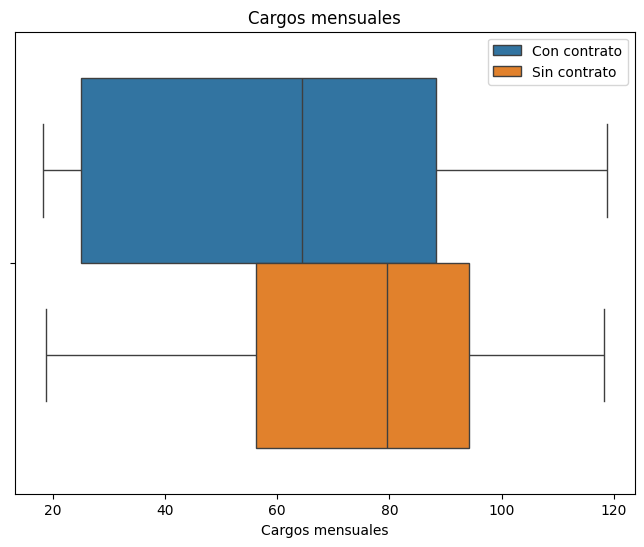

In [23]:
# Boxplot para cada tipo de cliente
plt.figure(figsize=(8,6))
sns.boxplot(x='MonthlyCharges', hue='ContractEnd', data=contract_df)
plt.title('Cargos mensuales')
plt.xlabel('Cargos mensuales')
plt.legend(['Con contrato', 'Sin contrato'])
plt.show()


***Conclusión***

Se puede observar que Los clientes que terminaron su contrato con la empresa, de media, tenían más cargos mensuales. Esto fue probablemente una de las razones principales por las que los clientes decidieron terminar su contrato.

### Los clientes que terminaron su contrato ¿tenían pareja e hijos?

Vamos a analizar si hay una posibilidad de que los clientes, que terminaron su contrato, fue porque ya tenían una pareja o dependientes.

In [24]:
merge_df = contract_df.merge(personal_df, on='customerID', how='left')

In [25]:
display(merge_df.sample(2))

customerID   BeginDate              EndDate            Type  \
2899  6164-HAQTX  2014-03-01                   No        Two year   
4326  1455-ESIQH  2019-12-01  2020-01-01 00:00:00  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges  ContractEnd  \
2899               No  Bank transfer (automatic)           53.95            0   
4326              Yes           Electronic check           89.10            1   

     gender  SeniorCitizen Partner Dependents  
2899   Male              0      No         No  
4326   Male              0      No         No

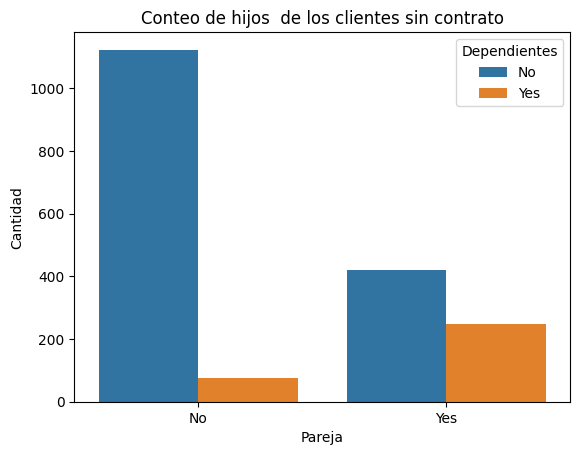

In [26]:
dft = merge_df[merge_df['ContractEnd'] == 1].groupby(['Partner', 'Dependents'])['Dependents'].value_counts()
dft = dft.reset_index()

sns.barplot(x=dft['Partner'], y=dft['count'], hue=dft['Dependents'])
plt.title("Conteo de hijos  de los clientes sin contrato")
plt.xlabel("Pareja")
plt.ylabel("Cantidad")
plt.legend(title="Dependientes")
plt.show()

***Conclusión***

Podemos observar que más de 1000 clientes que han terminado su contrato, no tienen pareja y no tienen personas dependientes. Esto representa más del 50% de los clientes totales que han terminado su contrato. Se puede decir que el tener una pareja y/o una persona dependiente no es un factor para que los clientes den por terminado el contrato con la empresa 

### ¿El tipo de contrato es igual entre los clientes que terminaron su contrato y ls clientes que siguen con su contrato?

Se va a analizar si los tipos de contrato es el mismo entre los clientes qe ya terminaron su contrato y los clientes que siguen son su contrato

**Clientes que ya terminaron su contrato**

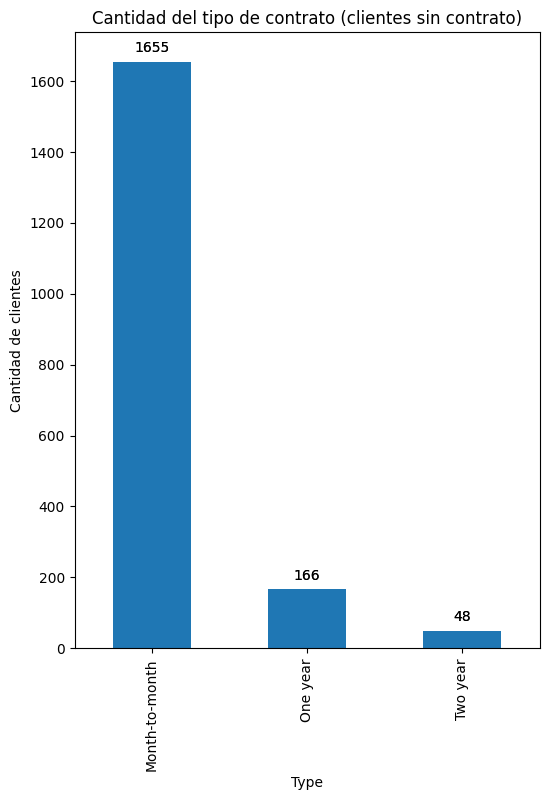

In [27]:
# vamos a graficar la columna Type de los clientes que ya no tienen contrato
# Filtramos el DF
dft = contract_df[contract_df['ContractEnd'] == 1].groupby('Type')['Type'].value_counts()

# Graficamos
dft.plot(kind='bar', title='Cantidad del tipo de contrato (clientes sin contrato)', figsize=(6,8), layout='constrained')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
for p in dft.plot(kind='bar').patches:
    dft.plot(kind='bar').annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), 
                                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

**Clientes con contrato vigente**

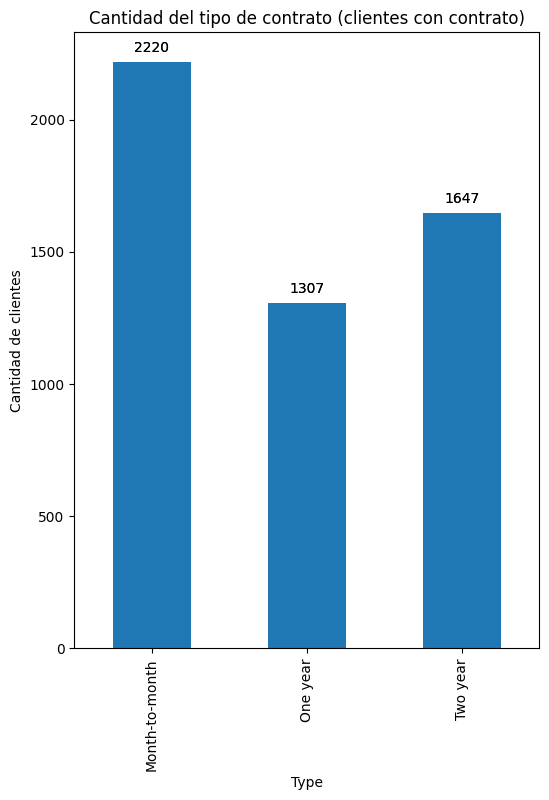

In [28]:
# vamos a graficar la columna Type de los clientes que siguen con contrato
# Filtramos el DF
dft = contract_df[contract_df['ContractEnd'] == 0].groupby('Type')['Type'].value_counts()

# Graficamos
dft.plot(kind='bar', title='Cantidad del tipo de contrato (clientes con contrato)', figsize=(6,8), layout='constrained')
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
for p in dft.plot(kind='bar').patches:
    dft.plot(kind='bar').annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), 
                                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

***Conclusión***

Con las gráficas podemos observar que el tipo de contrato que predomina en los dos tipos de clientes es el de mes con mes. Sin embargo, con los clientes que ya no tienen contrato el tipo de 1 año y el tipo de 2 años presentan una mínima cantidad. Mientras que, con los clientes que tienen su contrato vigente, podemos observar que el contrato de 1 año y dos años está presente en más del 50% de los clientes.

Podemos decir que el tipo de contrato afecta si los clientes mantienen su contrato o no.

## Modelos

Nuestra tarea es una tarea de clasificación binaria donde nuestro objetivo es la columna `'ContractEnd'`. Se van a entrenar tres modelos diferentes y se va a elegir el modelo con el mayor valor AUC-ROC. Pero antes es necesario preparar los datos para el entrenamiento de los modelos

### Juntando los datasets

Se van a juntar los datasets que se tienen en uno solo y se va a buscar arrglar los problemas de valores ausentes que se presenten. Ya se tiene el dataset `merge_df`, el cual ya tiene juntos tres datasets, falta agregar `internet_df`.

In [29]:
# Se agrega internet_df a merge_df
merge_df = merge_df.merge(internet_df, on='customerID', how='left').merge(phone_df, on='customerID', how='left')

In [30]:
# Se revisan los cambios realizados
display(merge_df.sample(2))

customerID   BeginDate EndDate      Type PaperlessBilling  \
4693  0463-TXOAK  2015-10-01      No  Two year               No   
6974  0422-UXFAP  2015-11-01      No  One year              Yes   

                PaymentMethod  MonthlyCharges  ContractEnd  gender  \
4693  Credit card (automatic)           25.60            0    Male   
6974         Electronic check           98.85            0  Female   

      SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
4693              0      No        Yes             NaN            NaN   
6974              0     Yes         No     Fiber optic             No   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
4693          NaN              NaN         NaN         NaN             NaN   
6974           No              Yes          No         Yes             Yes   

     MultipleLines  
4693           Yes  
6974           Yes

In [31]:
# Ahora se revisan los valores ausentes que el dataset tiene
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   ContractEnd       7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Los valores ausentes representan una gran cantidad de datos de nuestro dataset, se decide cambiar los valores NaN por la palbara 'None' debido a que uno de los modelos que se usaran no puede manejar los valores ausentes.

In [32]:
merge_df = merge_df.fillna('None')

Borramos las columnas `customerID`, `BeginDate` y `EndDate` porque el tanto el id del cliente como las fechas no son relevantes para el entrenamiento de los modelos.

Además, ya que se tienen los 4 datasets juntos. Cambiamos los nombres de las columnas para tener un estilo snake_case. Para esto se va a definir una función

In [33]:
def snake_case(name):
    string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()

In [34]:
# Eliminación de columnas
merge_df = merge_df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

# Cambiamos a un estilo snake case
merge_df = merge_df.rename(columns=lambda x: snake_case(x))

In [35]:
# Verificación de los cambios realizados
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   contract_end       7043 non-null   int64  
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

### Convertir valores Yes y No

Se van a convertir todas las columnas que tengan `'Yes'` y `'No'` para que al momento de hacer una codificación OHE no se generen columnas. Se establece una función para lograr esta tarea. Para los valores que tienen `'None'`, recordemos que estos valores inicialmente eran nulos debido a la unión de los 4 datasets, se va a tomar el valor que más aparezca (moda) y ese valor es el que se va colocar.

In [36]:
def yes_no_transform(df, columns):
    for column in columns:
        # Primero quitamos los valores None que pusimos
        df[column] = df[column].str.replace('None', df[column].mode().iloc[0])  # usamos iloc en dado caso que la columna tenga la misma cantidad de valores, sólo escogemos el primero
        
        # Cambiamos por 1 y ceros
        df[column] = df[column].map({'Yes': 1, 'No': 0, 'None':df[column].mode().iloc[0]})
        
        # También se cambia el tipo de datos
        df[column] = df[column].astype('int')

    return df

In [37]:
# Lista de columnas a transformar
columns_to_transform = ['paperless_billing', 'partner', 'dependents','multiple_lines','online_security','online_backup',
                        'device_protection','tech_support','streaming_tv','streaming_movies'] 

#  Se llama a la función para transformar el dataset 'data'
data = yes_no_transform(merge_df, columns_to_transform)

In [38]:
# Verificamos el cambio
display(merge_df.sample(3))

type  paperless_billing           payment_method  \
432   Month-to-month                  0         Electronic check   
5145        One year                  1  Credit card (automatic)   
1152  Month-to-month                  0             Mailed check   

      monthly_charges  contract_end gender  senior_citizen  partner  \
432             53.45             0   Male               0        0   
5145            25.70             0   Male               0        1   
1152            54.85             0   Male               0        0   

      dependents internet_service  online_security  online_backup  \
432            0              DSL                1              0   
5145           1             None                0              0   
1152           0              DSL                0              0   

      device_protection  tech_support  streaming_tv  streaming_movies  \
432                   1             0             0                 0   
5145                  0             0             0                 0   
1152                  0             0             1                 0   

      multiple_lines  
432                0  
5145               1  
1152               0

***Conclusión***

Ahora tenemos solamente 4 columnas que son categóricas

### Codificación OHE

Convertimos las variables categóricas en numéricas usando one-hot-encoding

In [39]:
# Codificación OHE
merge_ohe_df = pd.get_dummies(merge_df, drop_first=True)

# Comprobamos la codificación
print(merge_ohe_df.shape)

(7043, 21)


In [40]:
display(merge_ohe_df.sample(5))

paperless_billing  monthly_charges  contract_end  senior_citizen  \
978                   1           103.75             1               1   
3972                  1            50.90             0               0   
6087                  1            39.95             0               0   
669                   0            57.80             0               0   
1274                  1           101.15             0               0   

      partner  dependents  online_security  online_backup  device_protection  \
978         1           0                0              1                  1   
3972        0           0                1              0                  0   
6087        0           1                0              1                  0   
669         1           0                0              1                  1   
1274        1           1                1              0                  0   

      tech_support  ...  streaming_movies  multiple_lines  type_One year  \
978              0  ...                 1               1           True   
3972             0  ...                 0               0          False   
6087             0  ...                 0               0           True   
669              1  ...                 1               0          False   
1274             0  ...                 1               1          False   

      type_Two year  payment_method_Credit card (automatic)  \
978           False                                   False   
3972          False                                   False   
6087          False                                   False   
669            True                                   False   
1274           True                                   False   

      payment_method_Electronic check  payment_method_Mailed check  \
978                              True                        False   
3972                            False                        False   
6087                            False                        False   
669                             False                        False   
1274                            False                        False   

      gender_Male  internet_service_Fiber optic  internet_service_None  
978          True                          True                  False  
3972         True                         False                  False  
6087         True                         False                  False  
669         False                         False                  False  
1274        False                          True                  False  

[5 rows x 21 columns]

### Divisón del dataset

Se van a crear dos funciones para la división del dataset:
1. Función para dividir el dataset en features y target. El objetivo es la columna `'contract_end'`.
2. Función para dividir en el conjunto de entrenamiento y validación.

Se realizan dos funciones:

In [41]:
# Función para dividir el objetivo de las características
def features_target(data, column):
    features = data.drop(column, axis=1)
    target = data[column]
    return features, target

In [42]:
# Función para dividir en los conjuntos de validación y entrenamiento
def train_valid(features, target):
    fatures_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2,
                                                                                 random_state=12345)
    return fatures_train, features_valid, target_train, target_valid

Ahora llamamos a las funciones para crear los conjuntos. Se va a llamar para el dataset que está codofocado con OHE y para el dataset que no tiene codificación

In [43]:
# División en features y target del dataset con codificación OHE en la columna 'ContractEnd'
features, target = features_target(merge_ohe_df, 'contract_end')

In [44]:
# Set de entrenamiento y validación usando las características con codificación OHE
features_train, features_valid, target_train, target_valid = train_valid(features, target)

### Escalado de características

Se va a realizar un escalado de características de la columna única numérica que hay, esto se realiza porque tenemos una tarea de clasificación binaria y es posible que el peso de esa característica pueda cambiar las predicciones. Se va a crear uns función para escalar.

In [45]:
# Función para escalar características
def features_scaler(features_train, features_valid, numeric):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid

In [46]:
# Llamada a la función en las características del dataset sin codificación OHE
features_train, features_valid = features_scaler(features_train, features_valid, ['monthly_charges'])

### Balanceo de clases

Antes de ajustar el balanceo de clases, veamos como está el desequilibrio en el conjunto de entrenamiento:

In [47]:
# Recordamos el equilibrio de clases de la variable objetivo.
desequilibrio_features = target_train.value_counts(normalize=True)
desequilibrio_features

contract_end
0    0.735534
1    0.264466
Name: proportion, dtype: float64

Esto quiere decir que aproximadamente el 74% pertenece a la clase cero y el 26% pertenece a la clase 1. Es decir, la clase cero se repite 3 vaces más que la clase 1.

Se va a aplicar la técnica del sobremuestro y submuestreo para reslover este problema.

La creación de la función de la función `upsample` servirá para aplicar el sobremuestreo en el conjunto de entrenamiento. 

In [48]:
# Función para sobremuestreo
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    arg1 = pd.concat([features_zeros] + [features_ones] * repeat)
    arg2 = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsample, target_upsample = shuffle(arg1, arg2, random_state=12345)
    
    return features_upsample, target_upsample

In [49]:
# Vamos a establecer un repetidor 
repeat = 3

# Llamamos a la función en el conjunto de entrenamiento
features_train_up, target_train_up = upsample(features_train, target_train, repeat)

La creación de la función de la función `downsample` servirá para aplicar el subremuestreo en el conjunto de entrenamiento. 

In [50]:
# Función para submuestreo
def downsample(features, target, fraction):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    arg1 = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    arg2 = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsample, target_downsample = shuffle(arg1, arg2, random_state=12345)
    
    return features_downsample, target_downsample

In [51]:
# Vamos a establecer una fracción 
fraction = 0.2

# Llamamos a la función en el conjunto de entrenamiento
features_train_down, target_train_down = downsample(features_train, target_train, fraction)

### Función para modelos

Se va a crear una función para entrenar y hacer predicciones de los diferentes modelos:

In [52]:
# Función para entrenar y evaluar el mejor modelo
def eval_model(model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    predict_valid_prob = model.predict_proba(features_valid)[:,1]
    auc_roc = roc_auc_score(target_valid, predict_valid_prob)
    
    print(f'Modelo: {model.__class__.__name__}')
    print('Matriz de confusión:\n', confusion_matrix(target_valid, predict_valid))
    
    # Trazar la curva ROC
    fpr, tpr, _ = roc_curve(target_valid, predict_valid_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_roc

Para comprobar cuáles son los mejores hiperparámetros en los modelos a entrenar, se va a utilizar `GridSearchCV `. Para esto tambíen se va a crear una función:

In [53]:
# Función para seleccionar el mejor modelo
def grid_model(grid_search, features_train, target_train):
    grid_search.fit(features_train, target_train)
    
    best_model = grid_search.best_estimator_
    best_param = grid_search.best_params_
    return best_model, best_param

### Árbol de decisión

Primero se van a evaluar los datos de **sobremuestreo**.

Primero vamos a definir los parámetros que se van a medir

In [54]:
# Hiperparámetros del modelo
param_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10]
}

# Se crea el objeto GridSerachCV
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=12345), param_tree, cv=2, scoring='roc_auc')

Buscamos el mejor modelo llamando a la función `grid_model`

Modelo: DecisionTreeClassifier
Matriz de confusión:
 [[638 392]
 [ 81 298]]


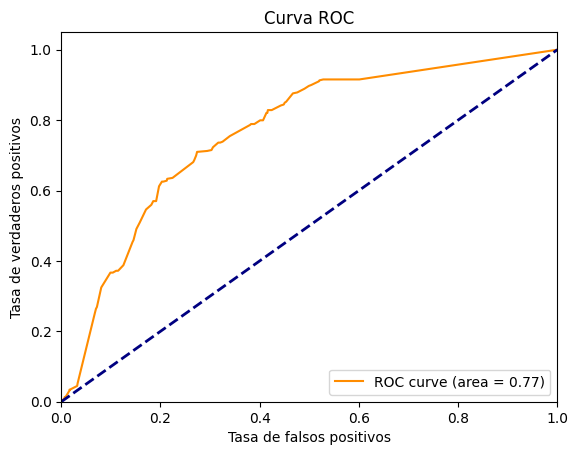

Valor AUC-ROC con datos de sobremuestro: 0.7665676153392935
Mejpres hiperparámetros:
 {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Tiempo del modelo: 4.270446062088013 segundos


In [55]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_tree_up, best_params = grid_model(grid_tree, features_train_up, target_train_up)
# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_tree_up, features_train_up, target_train_up, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de sobremuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

**Submuestreo**

Modelo: DecisionTreeClassifier
Matriz de confusión:
 [[629 401]
 [ 61 318]]


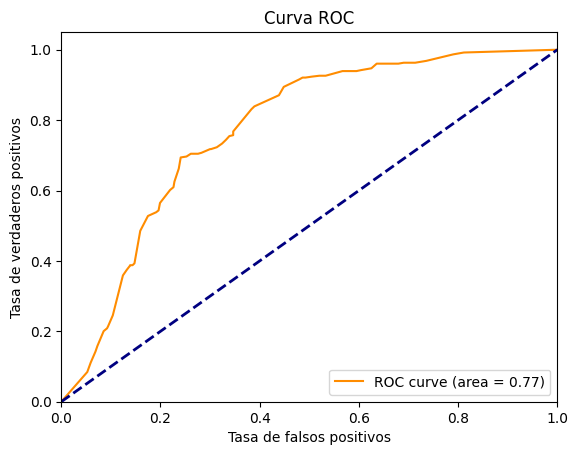

Valor AUC-ROC con datos de submuestreo: 0.7709749724620231
Mejpres hiperparámetros:
 {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Tiempo del modelo: 2.3936495780944824 segundos


In [56]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_tree_down, best_params = grid_model(grid_tree, features_train_down, target_train_down)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_tree_down, features_train_down, target_train_down, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de submuestreo:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

### Bosque Aleatorio de Decisión

**Sobremuestreo**

In [57]:
# Hiperparámetros del modelo
param_rfc = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Se crea el objeto GridSerachCV
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=12345), param_rfc, cv=2, scoring='roc_auc')

Modelo: RandomForestClassifier
Matriz de confusión:
 [[838 192]
 [189 190]]


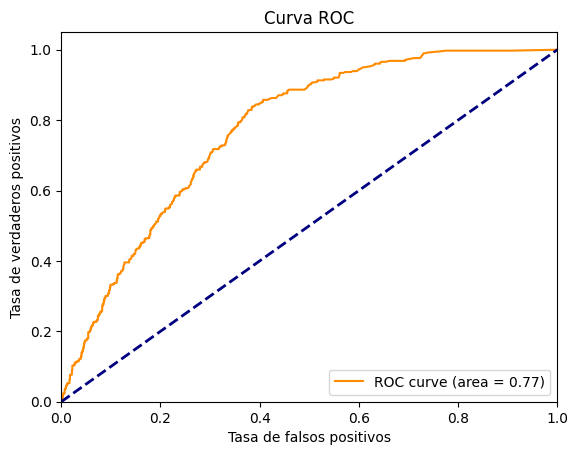

Valor AUC-ROC con datos de sobremuestro: 0.7728142531444527
Mejpres hiperparámetros:
 {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Tiempo del modelo: 229.75548386573792 segundos


In [58]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_rfc_up, best_params = grid_model(grid_rfc, features_train_up, target_train_up)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_rfc_up, features_train_up, target_train_up, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de sobremuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

**Submuestreo**

Modelo: RandomForestClassifier
Matriz de confusión:
 [[579 451]
 [ 36 343]]


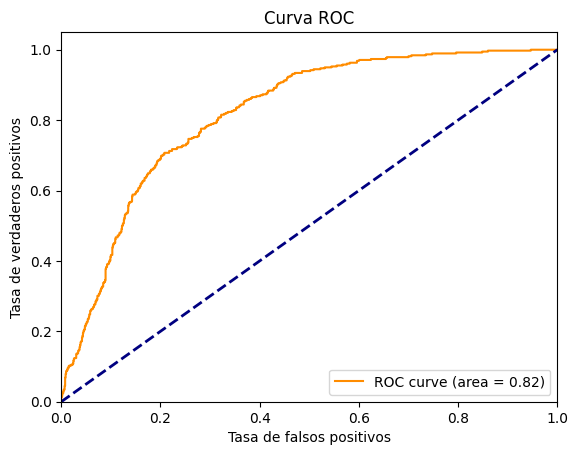

Valor AUC-ROC con datos de submuestreo: 0.8178036222045753
Mejpres hiperparámetros:
 {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Tiempo del modelo: 89.49300694465637 segundos


In [59]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_rfc_down, best_params = grid_model(grid_rfc, features_train_down, target_train_down)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_rfc_down, features_train_down, target_train_down, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de submuestreo:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

### Regresión Logística

**Sobremuestreo**

In [60]:
# Hiperparámetros del modelo
param_regression = {
    'solver':['lbfgs', 'liblinear', 'newton-cholesky']
}

# Se crea el objeto GridSerachCV
grid_regression = GridSearchCV(LogisticRegression(random_state=12345), param_regression, cv=2, scoring='roc_auc')

Modelo: LogisticRegression
Matriz de confusión:
 [[724 306]
 [ 79 300]]


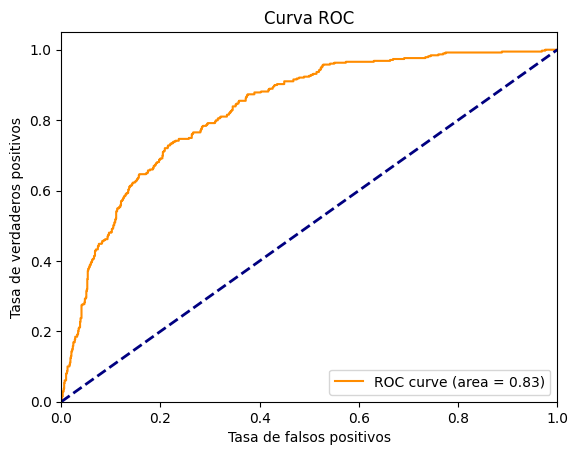

Valor AUC-ROC con datos de sobremuestro: 0.8292696672387735
Mejpres hiperparámetros:
 {'solver': 'liblinear'}
Tiempo del modelo: 0.3777952194213867 segundos


In [61]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_regression_up, best_params = grid_model(grid_regression, features_train_up, target_train_up)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc= eval_model(best_model_regression_up, features_train_up, target_train_up, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de sobremuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

**Submuestreo**

Modelo: LogisticRegression
Matriz de confusión:
 [[616 414]
 [ 45 334]]


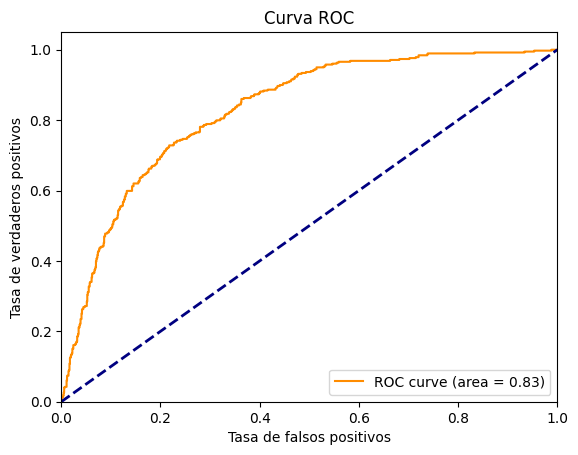

Valor AUC-ROC con datos de submuestro: 0.8276327586648564
Mejpres hiperparámetros:
 {'solver': 'liblinear'}
Tiempo del modelo: 0.2605903148651123 segundos


In [62]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_regression_down, best_params = grid_model(grid_regression, features_train_down, target_train_down)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_regression_down, features_train_down, target_train_down, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de submuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

### LightGBM

**Sobremuestreo**

In [63]:
# Hiperparámetros del modelo
param_lgbm = {
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[2, 5 , 8],
    'n_estimators':[100, 200, 300, 400, 500]
}

# Se crea el objeto GridSerachCV
grid_lgbm = GridSearchCV(LGBMClassifier(random_state=12345, verbose=100), param_lgbm, cv=2, scoring='roc_auc')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2235, number of negative: 2072
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.742667
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.573389
[LightGBM] [Debug] init for col-wise cost 0.000770 seconds, init for row-wise cost 0.000831 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 4307, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518923 -> initscore=0.075727
[LightGBM] [Info] Start training from score 0.075727
[LightGBM] [Warning] No further splits with positive gain, best g

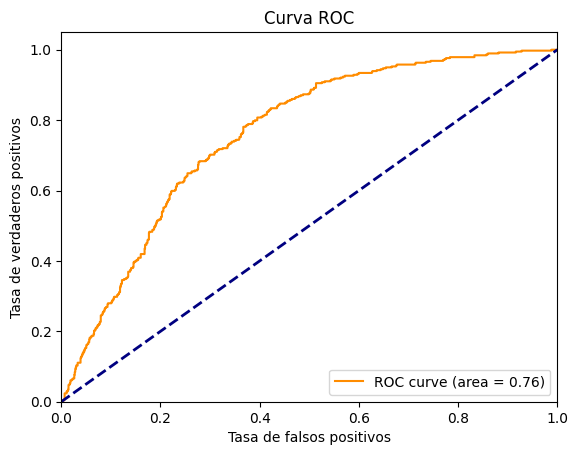

Valor AUC-ROC con datos de sobremuestro: 0.7580948843404973
Mejpres hiperparámetros:
 {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 500}
Tiempo del modelo: 11.849867820739746 segundos


In [64]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_lgbm_up, best_params = grid_model(grid_lgbm, features_train_up, target_train_up)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_lgbm_up, features_train_up, target_train_up, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de sobremuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

**Submuestreo**

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 745, number of negative: 414
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.773943
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.573618
[LightGBM] [Debug] init for col-wise cost 0.000175 seconds, init for row-wise cost 0.000319 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.642796 -> initscore=0.587518
[LightGBM] [Info] Start training from score 0.587518
[LightGBM] [Warning] No further splits with positive gain, best gai

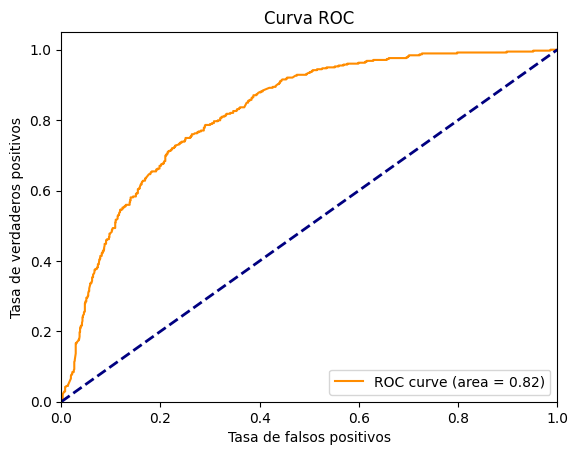

Valor AUC-ROC con datos de submuestreo: 0.8227374029766631
Mejpres hiperparámetros:
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Tiempo del modelo: 7.577960729598999 segundos


In [65]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_lgbm_down, best_params = grid_model(grid_lgbm, features_train_down, target_train_down)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_lgbm_down, features_train_down, target_train_down, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de submuestreo:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

### XGBoost

**Sobremuestreo**

In [66]:
# Hiperparámetros del modelo
param_xgb = {
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[2, 5, 6, 8],
    'n_estimators':[100, 200, 300, 400, 500]
}

# Se crea el objeto GridSerachCV
grid_xgb = GridSearchCV(XGBClassifier(random_state=12345), param_xgb, cv=2, scoring='roc_auc')

Modelo: XGBClassifier
Matriz de confusión:
 [[770 260]
 [149 230]]


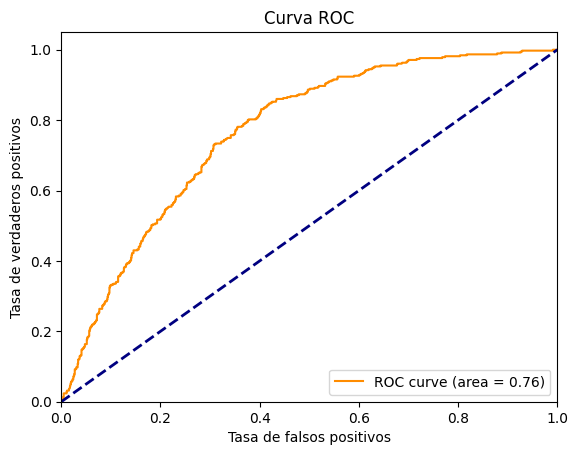

Valor AUC-ROC con datos de sobremuestro: 0.7645528601070779
Mejpres hiperparámetros:
 {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
Tiempo del modelo: 28.176557302474976 segundos


In [67]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_xgb_up, best_params = grid_model(grid_xgb, features_train_up, target_train_up)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_xgb_up, features_train_up, target_train_up, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de sobremuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

**Submuestreo**

Modelo: XGBClassifier
Matriz de confusión:
 [[542 488]
 [ 31 348]]


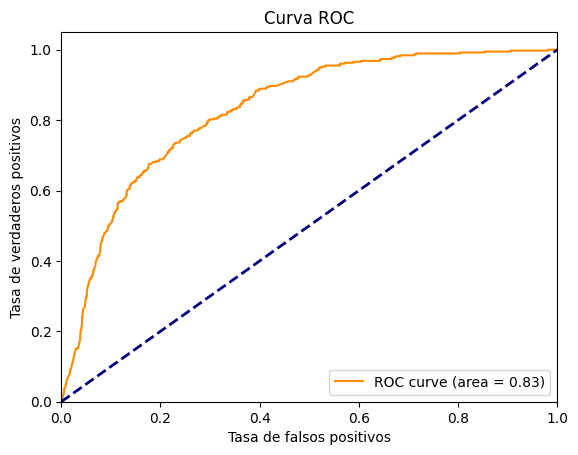

Valor AUC-ROC con datos de sobremuestro: 0.8291710428567769
Mejpres hiperparámetros:
 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
Tiempo del modelo: 22.01864266395569 segundos


In [68]:
inicio = time.time()
# Buscamos el mejor modelo
best_model_xgb_down, best_params = grid_model(grid_xgb, features_train_down, target_train_down)

# Ya tenemos el mejor modelo, ahora calculamos el valor AUC-ROC
auc_roc = eval_model(best_model_xgb_down, features_train_down, target_train_down, features_valid, target_valid)
fin = time.time()
tiempo_modelo = fin - inicio
print('Valor AUC-ROC con datos de sobremuestro:', auc_roc)
print('Mejpres hiperparámetros:\n', best_params)
print(f'Tiempo del modelo: {tiempo_modelo} segundos')

## Conclusión

Los dos mejores modelos son, de acuerdo con la métrica AUC-ROC:
1. Regresión Logística con el conjunto de sobremuestreo
    * Valor AU-ROC: 0.829269
    * Mejores hiperparámetros: {'solver':'liblinear'}
    * Tiempo de ejecución: 0.37 segundos

2. XGBosst con el conjunto de submuestreo
    * Valor AU-ROC: 0.829171
    * Mejores hiperparámetros: {'learning_rate':0.01, 'max_depth':2, 'n_estimators':500}
    * Tiempo de ejecución: 22.01 segundos

Ambos modelos presentan un buen rendimiento de acuerdo a la métrica, se puede escoger cualquiera de los dos modelos. Sin embargo, si el tiempo es importante para la tarea se debe escoger **Regresión Logística**

## Informe de solución

### Pasos realizados en el plan

Los pasos realizados para lograr entrenar los modelos son:
* Las columnas que contienen solo Yes/No se convierten en columnas numéricas cambiando los valores que tienen 'Yes' por un uno y los valores 'No' por un cero.
* Se realiza una codificación OHE (One Hot Encoding) para cambiar las columnas categóricas restantes por columnas numéricas.
* Se divide el dataset en `features` y `target` y a su vez en los conjuntos de entrenamiento y validación.
* Escalado de características numéricas.
* El dataset claramente tenía un desbalanceo de clases, se realizan los métodos de sobremuestreo y submuestreo para balancear las características.
* Se realizan dos funciones: la primera para el entrenamiento y evaluación de los modelos. La segunda para entrenar el moedlos y buscar los mejores hiperparámetros de cada modelo.
* Los modelos que se entrenan son: árbol de decisión, bosque aleatorio de decisión, regresión logística, LightGBM y XGBoost.

### Dificultades encontradas

El primer problema encontrado fue que se realizó una condificación OHE al dataset con sus valores originales, esto originó la creación de columnas innecesarias. Por lo que se decide cambiar las colunmas que tienen 'Yes/No' por unos y ceros.

Al cambiar las columnas con valores 'Yes/No'. Se presentó la dificultad de que había valores con el string `'None'`. Esto porque los valores tipo NaN que se tenían se cambiaron por dicha string en la etapa de preprocesamiento de los datos. Para solucionar esto, y al observar que los valores NaN no representaban una cantidad grande de datos, se toma la decisión de reemplazarlos por la moda de la columna.

Al entrenear los modelos se iba a repetir demasiado código, por lo que se decide realizar funciones para el entrenamiento y evaluación de los modelos.

El problema más grande encontrado fue para elegir los mejores hiperparámetros de los modelos. Primero se penso en poenrlos dentro de ciclos `for`. Sin embargo, este alcance resultaba un poco lento al evaluar tantos modelos. Al investigar sobre como escoger los mejores hiperparámetros encontré información sobre como utilizar `GridSearchCV`. Al colocar en un diccionario el nombre del hiperparámetro que se desea ir modificando, así como una lista con los distintos valores que se desean y después pasarlos al objeto `GridSearchCV` junto con el modelo que se desea evaluar, este encontrará la combinación de los mejores hiperparámetros para obtener la mejor métrica seleccionada, en este caso era el valor AUC-ROc. Una vez comprendido el funcionamiento se crea una función para evitar repetir el código en cada modelo.

### Pasos clave

Considero que todos los pasos son necesarios para poder encontrar el mejor modelo. Sin embargo, considero que el balanceo de clases y el uso de `GridSearchCV` son los pasos clave para obtener el mejor modelo.

Justificación: El dataset presentaba un desbalanceo de clases muy grande, al solucionar esto los modelos puedieron realizar de mejor manera su tarea, ya que sin esto es muy probable eu ningún modelo tuviera un valor AUC-ROC esperado.

Al hacer uso de `GridSearchCV` se realiza una combinación de diferentes hiperparámetros y se seleccionan los mejores. Sin este paso hubiera sido muy tardado ralizar un bucle para buscar los mejores de forma un poco más "manual".

### Modelo final

Cómo se dice en las conclusiones del proyecto, el mejor modelo es el de **Regresión Logística** entrenado con el método de submuetreo para balanceo de clases. Dicho modelo obtuvo un valor ***AUC-ROC*** de 0.83 y un ***tiempo de ejecución*** de 0.37 segundos.